In [ ]:
import tensorflow as tf
import numpy as np
# Tensorflow Dist
import tensorflow_probability as tfp
tfd = tfp.distributions

from collections import deque # Used to have limited arrays

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import os
import re   #regex
import time
import datetime


from datetime import datetime

# Libs for Images
from PIL import Image
import imageio

import glob #it does pattern matching and expansion <- Retrieving filenames on system and such



#import itertools
#from sklearn.metrics import confusion_matrix , classification_report

# Manipulate the cells output
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 

# GOOGLE COLAB ENV OR NOT
COLAB = False

if COLAB:
    from google.colab import drive
    #Google Drive
    drive.mount('/content/drive')
    # Weight And Biases Data Log
    !pip install wandb -qqq


# Path settings
base_path = '/content/drive/My Drive/' if COLAB else os.getcwd()
path_to_TrackGAN = base_path + 'Colab Notebooks/TrackGAN/' if COLAB else base_path + "/experiments"
dataset_dir = os.path.join(base_path, "DATA_Rep/TORCS tracks")  if COLAB else os.path.join(base_path, "TORCS tracks")
# Custom Libraries Path
import sys
sys.path.append( os.path.join(base_path,'Libs'))

# Configure the logging
#import logging 
#logging.basicConfig( level=logging.DEBUG)
#logging.basicConfig(format=formatter, level=logging.DEBUG)


# Reloading Custom Libraries
import importlib

# Custom Libraries Import
import keras_utils
import keras_models
import image_utils
import train_asses
import data_utils
import custom_metrics
import datasets_manager
import keras_model_wrappers
import misc
import structures

# Weight And Biases Data Log
import wandb
wandb.login(key = "USERKEY")

In [3]:
# Reload Libraries
def rlib():
  libs = [keras_utils , keras_models , image_utils, train_asses, data_utils , custom_metrics, datasets_manager, keras_model_wrappers, misc]
  for lib in libs:
    importlib.reload(lib)

Found 37 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Min : -1.0, Max : 1.0 Values


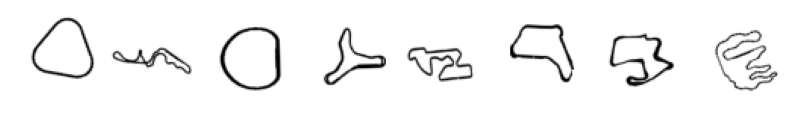

In [37]:
rlib()
BATCH_SIZE = 37
n_class = 3
augment_data = True
mod_data = "/mod_bitnot"
img_w, img_h = 64,64
# Mnist 0-9 digits dataset
#X_, Y_ = datasets_manager.mnist_digit_dataset()
# Create Fake Dataset FOR TESTING RELATIVE DATA DISTRIBUTION
#X_, Y_= datasets_manager.dummy_RGB_dataset()
# Some image trasformation applied
#X_, Y_= datasets_manager.dummy_RGB_dataset_transformed()
#training_dataset, distributions = datasets_manager.pixelart_dataset(BATCH_SIZE)
training_dataset = datasets_manager.TORCS_tracks_loader(batch_size=BATCH_SIZE, preprocessing_function = image_utils.normalize_images, class_mode = "sparse", validation_split = 0, 
                                                        apply_data_augmentation = augment_data, image_size = [img_w,img_h], dataset_dir = dataset_dir + mod_data, cval = 255) # Images returned are Normalized (-1,1)
distributions = None


In [ ]:
def flood_fill_single(im, seed_point):
    """Perform a single flood fill operation.

    # Arguments
        image: an image. the image should consist of white background, black lines and black fills.
               the white area is unfilled area, and the black area is filled area.
        seed_point: seed point for trapped-ball fill, a tuple (integer, integer).
    # Returns
        an image after filling.
    """
    pass1 = np.full(im.shape, 255, np.uint8)

    im_inv = cv2.bitwise_not(im)

    mask1 = cv2.copyMakeBorder(im_inv, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
    _, pass1, _, _ = cv2.floodFill(pass1, mask1, seed_point, 0, 0, 0, 4)

    return pass1 

image_utils.display_multiple_image( [flood_fill_single(imagess[1], (0,0))] )


In [ ]:
rlib()
image_utils.plot_channels_dist( [channel_dist, channel_dist], image_channels = 1, title = ["Original Data Color Per Channel Distribution" , "Gen Data Color Per Channel Distribution"] )

In [8]:
rlib()

latent_space_matching = True
use_classification = True
cont_variables = 1

#generator = keras_models.infogan_generator(noise_input=100, cat_inputs = 3, cont_inputs = 1, channels = 1)
#generator = keras_models.infogan_generator(noise_input=100, cat_inputs = 3, cont_inputs = cont_variables, channels = 1)
generator = keras_models.CGAN_generator(latent_dim = 100, n_class = 3)
#generator.summary()
#tf.keras.utils.plot_model(gen, show_shapes=True)


#discriminator, q_model = keras_models.infogan_discriminator(n_class = n_class, cont_outputs = cont_variables, input_shape=(64, 64, 1), latent_space_output = True)
discriminator = keras_models.CGAN_discriminator(n_class= 3, input_shape = [64, 64, 1], latent_space_output = latent_space_matching, use_classification= use_classification)
discriminator.summary()
#tf.keras.utils.plot_model(q_model, show_shapes=True)
tf.keras.utils.plot_model(discriminator, show_shapes=True)


2022-11-20 14:19:32.114657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 128)  1152        ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 20)        60          ['input_3[0][0]']                
                                                                                            

In [ ]:
rlib()
run_name = "CGAN CLASS_LM G1M, D1.3M UPDATED_GRAD BITNOT"

models = [generator, discriminator]
models_name = ["Generator", "Discriminator"]


# Generate or Restore WANDB Run
try:
  run_id = misc.load_json_object(path_to_TrackGAN + f"runs/{run_name}")
  print(f"Restored run id {run_id} from experiment name {run_name}")
except FileNotFoundError:
  # Generate a new run id
  run_id = wandb.util.generate_id()
  print(f"New run id {run_id} generated for experiment name {run_name}")
  # Store the id to file
  misc.save_object_to_json(path_to_TrackGAN + f"runs/{run_name}", run_id)

# Add wandb finish before reinitialize. -- Modify stuff
try:
  wandb.finish()
except Exception as e:
  print(e)


# 🐝 1️⃣ Start a new run to track this script
wandb.init(
    # Set the project where this run will be logged
    project="TrackGAN", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    #name=f"experiment_{run}", 
    name = run_name,
    # Resume last ran
    id = run_id,
    resume=True,
    # Track hyperparameters and run metadata
    config={
    "learning_rate_G": 2e-5,
    "learning_rate_D" : 2e-4,
    "exponential_decay_init" : 1e-3,
    "min_lr" : 2e-5,
    "decay_rate" : 0.97,
    "decay_steps" : 100,
    "beta1_dcgan" : 0.5,
    "architecture": "CGAN",
    "dataset": "TORCS",
    "data_variant" : "BITNOT MOD",
    "epochs": 50,
    "noise_dim": 100,
    #"dropout": np.random.uniform(0.01, 0.80),
    "batch_size": BATCH_SIZE,
    "data_augmentation": augment_data,
    "smooth_loss" : True,
    "embeddings" : True,
    "Latent Matching" : latent_space_matching,
    "Output Classification": use_classification,
    "image_size" : f"{img_w}x{img_h}",
    })

wandb_config = wandb.config

In [ ]:
# Log the models architercutre to wandb
misc.wandb_log_models_architecture(models, wandb, path_to_TrackGAN, models_name)

**Discriminator loss**

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.


**Generator loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
rlib()


# Disc/Gen Losses
  #Smoothed Disc loss or normal
discriminator_loss = train_asses.discriminator_BinaryCrossEntropy_smoothed if wandb_config.smooth_loss else train_asses.discriminator_BinaryCrossentropy
generator_loss = train_asses.generator_BinaryCrossentropy


# Exponential Learning rate
if wandb_config.exponential_decay_init :
    print("Configuring Exponential Learning Rate ...")
    decay_lr = misc.DecayLRWrapper(init_lr = wandb_config.exponential_decay_init, min_lr = wandb_config.min_lr, decay_rate = wandb_config.decay_rate, decay_steps = wandb_config.decay_steps)
    lr = decay_lr.decayed_learning_rate_mtresh_ffile
# Standard Learning Rate
else:
    lr = wandb_config.learning_rate_G

# Use Exponential Decay or standard lr
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1= wandb_config.beta1_dcgan)
discriminator_optimizer = tf.keras.optimizers.Adam(wandb_config.learning_rate_D, beta_1= wandb_config.beta1_dcgan)
#q_optimizer = tf.keras.optimizers.Adam(decayed_learning_rate_mtresh_ffile if wandb_config.exponential_decay_init else wandb_config.learning_rate_D, beta_1= wandb_config.beta1_dcgan)


checkpoint_dir = path_to_TrackGAN + 'training_checkpoints/' + wandb.run.name

checkpoint = tf.train.Checkpoint(step=tf.Variable(1),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 )


# Limit Number of checkpoints and Manage restoring
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 3 , checkpoint_name= 'tf_ckpts')


In [132]:
x = tf.constant( [3.0, 2.0])
#h = tf.constant( [1.0,1.0])
with tf.GradientTape(persistent=True) as g:
  g.watch(x)
  #g.watch(h)
  h = 3*x
  y = 2*x
  z = 2*h
dy_dx = g.gradient(y, x)
dz_dx = g.gradient(z, x)
total_arr = g.gradient( [y,z], [x,h] )
#total_sum = y+z
#red_mean = tf.reduce_mean((y,z))
#total_reduce_mean = g.gradient(red_mean, [x,h])
#total_sum = g.gradient(total_sum, [x,h])

print(dy_dx)
print(dz_dx)
print(total_arr)


tf.Tensor([2. 2.], shape=(2,), dtype=float32)
tf.Tensor([6. 6.], shape=(2,), dtype=float32)
[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([8., 8.], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]


In [ ]:
rlib()

noise_dim = wandb_config.noise_dim
num_examples_to_generate = 36

# Reuse this same seed overtime
# to visualize progress in the animated GIF)

# Seeds locations
seed_save_path = os.path.join(base_path,  'DATA_Rep/CGANTorcs36.npy') if COLAB else os.path.join(base_path, "seeds", 'CGANTorcs36.npy')
cond_seed_save_path = os.path.join(base_path,  'DATA_Rep/CGANT36.npy') if COLAB else os.path.join(base_path,"seeds", 'CGANT36.npy')

# Restore or create a new noise seed
noise_seed = train_asses.get_seed(shape = [num_examples_to_generate , noise_dim] , seed_save_path = seed_save_path )


# INFO GAN
if False:
    #noise_seed = train_asses.get_infogan_seed( shape = [num_examples_to_generate, noise_dim], n_class = n_class, seed_save_path= seed_save_path)
    generator_seed = train_asses.get_infogan_seed_embeddings( shape = [num_examples_to_generate, noise_dim], n_class = n_class, cont_variables = cont_variables, seed_save_path= seed_save_path)
    print(f"\nNoise input shape {generator_seed.shape}")


# CGAN
if True:
    target_seed = train_asses.get_cond_seed(num_examples_to_generate,n_class = n_class, seed_save_path= cond_seed_save_path, as_one_hot = False)
    generator_seed = [noise_seed, target_seed]

    print(f"\nNoise input shape {noise_seed.shape}\nConditioning input shape {target_seed.shape}")



In [14]:
n_cont_variables = 3
cont_dist = tfp.distributions.Normal(loc=[0]*n_cont_variables, scale=[1]*n_cont_variables)
cont_input = cont_dist.sample(100)
#label = tf.random.uniform([2], minval=0, maxval=3, dtype=tf.int32)
#label

# Use Gaussian distributions to represent the output
dist = tfp.distributions.Normal(loc=[1]*n_cont_variables, scale=[1]*n_cont_variables)
# Losses (negative log probability density function as we want to maximize the probability density function)
cont_loss = tf.reduce_mean(-dist.log_prob(cont_input))
cont_loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.9758669>

In [102]:
rlib()
# Wrap Tensorflow Metrics into a custom metric-wrapper
custom_gan_metrics = [custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryAccuracy, name = "Disc Accuracy",GAN_module = 'discriminator', threshold = 0.5),
                      custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryCrossentropy, name = "Disc CrossH",GAN_module = 'discriminator', from_logits = False),
                      custom_metrics.gan_generator_metric(tf.keras.metrics.BinaryAccuracy, name = "Gen Accuracy",GAN_module = 'generator', threshold = 0.5),
                      custom_metrics.gan_generator_metric(tf.keras.metrics.BinaryCrossentropy, name = "Gen CrossH",GAN_module = 'generator', from_logits = False),
                      custom_metrics.single_input_metric(tf.keras.metrics.Mean, name = "Q_Loss", GAN_module = 'generic_metric'),
                      custom_metrics.single_input_metric(tf.keras.metrics.Mean, name = "Latent Matching Loss", GAN_module = 'generic_metric'),
                      custom_metrics.single_input_metric(tf.keras.metrics.Accuracy, name="accuracy", GAN_module = 'generic_metric'),
                      custom_metrics.single_input_metric(tf.keras.metrics.Mean, name="Categorical Loss", GAN_module = 'generic_metric')
                      ]


# Wrap the keras model
# Info GAN + LM
#GAN_Model = keras_model_wrappers.InfoGAN_LM_wrapper(q_model, cont_variables, wandb.run.name, discriminator, generator, BATCH_SIZE, noise_dim, num_classes = n_class,
#                                                 gan_metrics = custom_gan_metrics, base_path = path_to_TrackGAN + f"saved_model/{wandb.run.name}/")

# STANDARD INFO GAN
#GAN_Model = keras_model_wrappers.InfoGAN_wrapper(q_model, cont_variables, wandb.run.name, discriminator, generator, BATCH_SIZE, noise_dim, num_classes = n_class,
#                                                 gan_metrics = custom_gan_metrics, base_path = path_to_TrackGAN + f"saved_model/{wandb.run.name}/")

# DC GAN
#GAN_Model = keras_model_wrappers.BASE_GAN(wandb.run.name, discriminator, generator, BATCH_SIZE, noise_dim, num_classes = n_class, gan_metrics = custom_gan_metrics, base_path = path_to_TrackGAN + f"saved_model/{wandb.run.name}/")

# CGAN
#GAN_Model = keras_model_wrappers.CGAN_wrapper(wandb.run.name, discriminator, generator, BATCH_SIZE, noise_dim, num_classes = n_class,
#                                              gan_metrics = custom_gan_metrics, base_path = path_to_TrackGAN + f"saved_model/{wandb.run.name}/")

# CGAN+Latent space matching
#GAN_Model = keras_model_wrappers.CGAN_LM_wrapper(wandb.run.name, discriminator, generator, BATCH_SIZE, noise_dim, num_classes = n_class,
#                                              gan_metrics = custom_gan_metrics, base_path = path_to_TrackGAN + f"saved_model/{wandb.run.name}/")

# CGAN+Latent space matching + CLass Loss
GAN_Model = keras_model_wrappers.CGAN_LM_Classification_wrapper(wandb.run.name, discriminator, generator, BATCH_SIZE, noise_dim, num_classes = n_class,
                                              gan_metrics = custom_gan_metrics, base_path = path_to_TrackGAN + f"saved_model/{wandb.run.name}/")



GAN_Model.compile(discriminator_optimizer, generator_optimizer, discriminator_loss, generator_loss)


Things to look for:
- Check that neither the generator nor the discriminator model has "won". If either the gen_gan_loss or the disc_loss gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the disc_loss, a value below 0.69 means the discriminator is doing better than random on the combined set of real and generated images.
- For the gen_gan_loss, a value below 0.69 means the generator is doing better than random at fooling the discriminator.

In [103]:
# With random weights initialization the accuracy on fake images is very high, due to low weights -> low weights output -> sigmoid -> 0 -> 0 is good for fake images.
# The discriminator won't learn how to classify real images, will just be resilient to the generaor -> from epoch 1 and on Accuracy on real images = 0

# USE AVG/MAX POOLING for image smoothness
# Add avg pooling as last layer - to smooth images coming out of the generator
# The log loss when you have conditioning cannot be computed conditioned_image vs entire original dataset. It won't match - > If the generated seed distribution is not equal to the dataset intrinsic distribution of classes


# Find a way to Introduce the variance in the image
# image sum log loss uses the mean of the generated images to calculate the probability of that to be sampled on the real dist
# -> calculate the distance between the real dist and the generated image dist

# Look into different architecture representation layers for the low-dimensional high-level features

# Plot latent space of real image vs normal image -> shapes


rlib()
image_save_path = path_to_TrackGAN + 'Generated Images/' + wandb.run.name +'/'

# Check if a checkpoint exists
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)





with tf.device('/device:GPU:0'):
  try:
      train_asses.train(training_dataset, wandb_config.epochs, valid_dataset= None, starting_epoch= checkpoint.step.numpy(), summary_writer= None, generator= generator, gen_seed= generator_seed,
                        checkpoint_manager= checkpoint_manager, distributions= distributions, DEBUG= False, BATCH_SIZE= BATCH_SIZE,
                        image_save_path= image_save_path, model = GAN_Model, wandb = wandb, steps_per_epoch = 600)
  except KeyboardInterrupt:
      #print("\nHalting the training process and finalizing the wandb run")
      # End the wandb run
      #wandb.finish()
      pass

Tracing... 
Tensor("strided_slice:0", shape=(3, 3), dtype=float32)
Tensor("strided_slice_1:0", shape=(3,), dtype=float32)
Tensor("categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("one_hot_1:0", shape=(37, 3), dtype=float32)
Tensor("model_1/GAP_SOFTMAX_OUT/Softmax_1:0", shape=(37, 3), dtype=float32)


In [ ]:
# Restore latest checkpoint
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)


In [ ]:
GAN_Model.sample_from_model(num_examples = 8)

In [ ]:

model_name = "InfoGAN  6MG-1.7MD  W_IMAGES"
#os.listdir(path_to_TrackGAN+"/test")
#os.remove(path_to_TrackGAN+"/test/Documento senza titolo.gdoc")
#os.listdir(path_to_TrackGAN+"/test")
rlib()
GAN_Model = keras_model_wrappers.InfoGAN_LM_wrapper(q_model, "InfogAnne", None, None, 38, 100, num_classes = 3,
                                                    base_path = path_to_TrackGAN + f"saved_model/{model_name}/", max_saved_models = 3)



In [ ]:
GAN_Model.sample_from_model( num_examples = 12, explore_var = "cat" )
GAN_Model.sample_from_model( num_examples = 12, explore_var = "cont", sampling_range = [-1, 1] )
#GAN_Model.sample_from_model( num_examples = 12, explore_var = "cont", sampling_range = [-10, 10] )


In [ ]:
image_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'

anim_file = path_to_TrackGAN + 'Generated Images/' + model_name + '.gif'

image_utils.generate_GIF(image_path, anim_file)

In [ ]:
#!pip install  git+https://github.com/tensorflow/docs
#import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

In [ ]:
# RESTORE MODEL FROM FILE
model_name = "CGAN REP BEST MODEL/generator"
pathToModel = path_to_TrackGAN + "saved_model/" + model_name

generator = keras_utils.loadModel(pathToModelCheckpoints = pathToModel, best_model = False)

In [ ]:
rlib()

n_samples = 24
noise_dimension = 100

noise_seed = train_asses.get_seed(shape = [n_samples , noise_dimension] , seed_save_path = None )
#noise_seed = train_asses.get_infogan_seed( shape = [n_samples, noise_dimension], n_class = n_class, seed_save_path= seed_save_path)
#generator_seed = train_asses.get_infogan_seed_embeddings( shape = [n_samples, noise_dimension], n_class = n_class, seed_save_path= seed_save_path)

# Conditioning seed
target_seed = train_asses.get_cond_seed(n_samples,n_class = n_class, seed_save_path= None, as_one_hot = False)
generator_seed = [noise_seed, target_seed]

gen_images = generator.predict(generator_seed)


image_utils.display_multiple_image( gen_images, denormalize = True, size = [1800,1800])
image_utils.are_images_closed(gen_images, silent_mode = True)

In [ ]:
rlib()

tracks_to_generate = 25
tracks_generated = []
num_classed = 3

while( len(tracks_generated) < tracks_to_generate ):
  n_samples = 15
  noise_dimension = 100
  # Noise seed
  noise_seed = train_asses.get_seed(shape = [n_samples , noise_dimension] , seed_save_path = None )
  # Conditioning seed
  target_seed = train_asses.get_cond_seed(n_samples,n_class = num_classed, seed_save_path= None, as_one_hot = False)
  # Input seed
  generator_seed = [noise_seed, target_seed]
  # Generate images
  gen_images = generator.predict(generator_seed)

  valid_images_arr = image_utils.are_images_closed(gen_images, silent_mode = True)

  tracks_generated = tracks_generated + valid_images_arr
  # Discard the tracks in excess
  tracks_generated = tracks_generated[:tracks_to_generate]



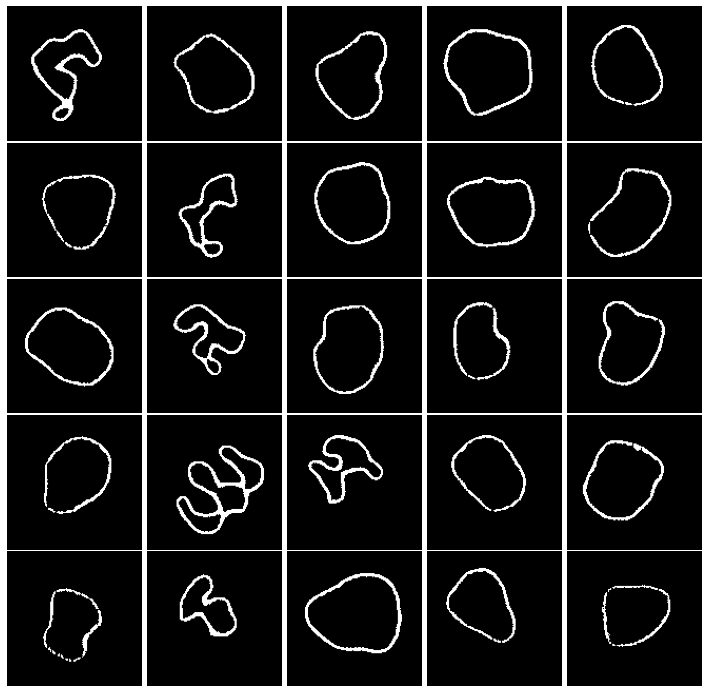

In [7]:
rlib()
image_utils.display_multiple_image( tracks_generated, denormalize = True, size = [900,900], inline= False)

In [ ]:
#TESTING DATA GENERATOR
# RESTORE MODEL FROM FILE
model_name = "CGAN REP BEST MODEL/generator"
pathToModel = path_to_TrackGAN + "/saved_model/" + model_name

generator = keras_utils.loadModel(pathToModelCheckpoints = pathToModel, best_model = False)


In [197]:
rlib()
model_gen = datasets_manager.Syntethic_Model_Generator(generator, 3, 100)

#gen_images = model_gen.next()
#image_utils.display_multiple_image( gen_images, denormalize = True, size = [900,900], inline= False)
#model_gen.sample_labels(16)

tf.Tensor([0 1 1], shape=(3,), dtype=int32)
(16,)
(16, 128, 128, 1)
Min : 0.0, Max : 255.0


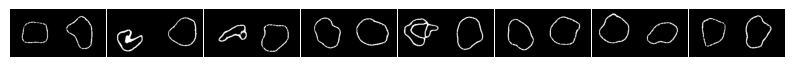

In [198]:
rlib()
merge_gen = datasets_manager.Merge_Generator( training_dataset, model_gen)

for x, y  in merge_gen:
  #print(y)
  
  print(y[:3])
  print(y.shape)
  print(x.shape)
  #print(x.shape)
  print(f"Min : {np.min(x)}, Max : {np.max(x)}")
  image_utils.display_multiple_image(x, denormalize=True, size=[1000,1000])

  ## SEARCH OPEN CLOSED IMAGE ---
  #images = np.array( x)
  break